In [ ]:
import torch,torchvision,os,PIL,pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import CelebA

# Show function
def show(tensor,num=25,name=""):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num],nrow=5).permute(1,2,0).numpy()

  plt.imshow(grid.clip(0,1))
  plt.show()

# Hyperparms and gen Params
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200
device = "cuda" if torch.cuda.is_available() else "cpu"

cur_step = 0
crit_cycles = 5
gen_losses = []
crit_losses = []
show_step = 35
save_step =  35



In [ ]:
# Generator

class Generator(nn.Module):
  def __init__(self,z_dim=64,d_dim=16):
    super().__init__()

    self.z_dim=z_dim

    self.gen = nn.Sequential(
        # new width and height : (n-1)*stride - 2*padding +ks
        # we begin with 1x1 image with z_dim number of channels
        nn.ConvTranspose2d(z_dim,d_dim * 32 ,kernel_size=4,stride=1,padding=0),# size : 4x4 (200,512)
        nn.BatchNorm2d(d_dim*32),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(d_dim*32,d_dim*16,4,2,1), # 8x8 (512 , 256)
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(d_dim*16,d_dim*8,4,2,1), # 16 x 16 (256,128)
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(d_dim*8,d_dim*4,4,2,1), # 32 x 32 (128 - 64)
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(d_dim*4,d_dim*2,4,2,1), # 64 x 64 (64 -32)
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(d_dim*2,3,4,2,1), # 128 x 128 (32- 16)
        nn.Tanh() ### result from -1 to 1
    )

  def forward(self,noise):
    x = noise.view(len(noise),self.z_dim,1,1) # 128 x 200 x 1 x 1
    return self.gen(x)

def gen_noise(num,z_dim,device=device):
  return torch.randn(num,z_dim,device=device) # noise vectors

In [ ]:
## Critic model

class Critic(nn.Module):
  def __init__(self,d_dim=16):
    super().__init__()

    self.crit = nn.Sequential(
        # (n+2*pad-ks)//stride + 1

        # 128 x 128
        nn.Conv2d(3,d_dim,4,2,1), # 64 x 64 \ 3 - 16
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim,d_dim*2,4,2,1), ## 32 x 32  \ 16- 32
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*2,d_dim*4,4,2,1), ## 16 x 16  \ 32 - 64
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*4,d_dim*8,4,2,1), ## 8 x 8  \ 64 - 128
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*8,d_dim*16,4,2,1), ## 4 x 4  \ 128 - 256
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*16,1,4,1,0 ), ## 1 x 1  \ 256 - 1

    )

  def forward(self,image):
    # 128 x 3 x 128 x 128
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    crit_pred = crit_pred.view(len(crit_pred),-1) # 128 x 1
    return crit_pred

In [ ]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!mkdir data
!cd data
!kaggle datasets download -d jessicali9530/celeba-dataset
!cp /content/celeba-dataset.zip /content/data
!unzip /content/data/celeba-dataset.zip -d /content/data

In [ ]:
path_images = "/content/data/img_align_celeba/img_align_celeba"

class Dataset(Dataset):
  def __init__(self,path,size=128,lim=10000):
    self.sizes = [size,size]
    items, labels = [],[]

    for data in os.listdir(path)[:lim]:
      #path './data/img_align_celeba/img_align_celeba'
      #data '114526.jpg'
      item= os.path.join(path,data)
      items.append(item)
      labels.append(data)

    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # (178 , 218 )
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3
    data = np.transpose(data,(2,0,1)).astype(np.float32, copy=False) # 3 x 128 x 128
    data = torch.from_numpy(data).div(255) # from 0 to 1

    return data,self.labels[idx]


In [ ]:
# Creating the Dataset and the DataLoader

ds = Dataset(path_images,size=128,lim=10000)
dataloader = DataLoader(ds,batch_size=batch_size,shuffle=True,pin_memory=True,num_workers=2)

# Creating the Models

gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.9))
crit_opt = torch.optim.Adam(crit.parameters(),lr=lr,betas=(0.5,0.9))

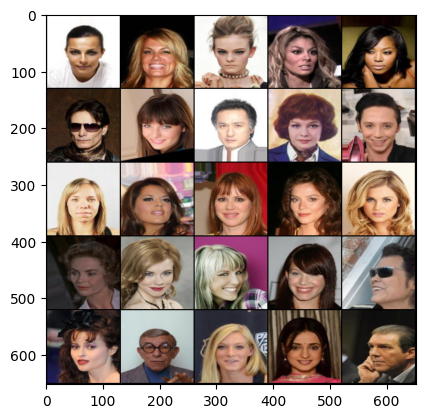

In [ ]:
x,y = next(iter(dataloader))
show(x)

In [ ]:
## gradient penalty

def get_gp(real,fake,crit,alpha,gamma=10):
  mix_images = real * alpha + fake * (1 - alpha) # 128 x 3 x 128 x 128
  mix_scores = crit(mix_images) # 128 x 1

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs = torch.ones_like(mix_scores),
      retain_graph = True,
      create_graph = True
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient), -1) # 128 x 49152
  gradient_norm = gradient.norm(2,dim=1)
  gp = ((gradient_norm -1)**2).mean()

  return  gp

In [ ]:
## Save and load checkpoints

!mkdir models
root = "./models/"

def save_checkpoint(name):
  torch.save({
      'epoch' : epoch,
      'model_state_dict' : gen.state_dict(),
      'optimizer_state_dict' : gen_opt.state_dict()
              },
             f"{root}G-{name}.pkl" )

  torch.save({
      'epoch' : epoch,
      'model_state_dict' : crit.state_dict(),
      'optimizer_state_dict' : crit_opt.state_dict()
              },
             f"{root}C-{name}.pkl" )

  print("Saved checkpoint")

def load_checkpoint(name):
  checkpoint = torch.load(f"{root}G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")

mkdir: cannot create directory ‘models’: File exists


In [ ]:
epoch=1
save_checkpoint("test")
load_checkpoint("test")

Saved checkpoint
Loaded checkpoint


In [ ]:
## Training loop

for epoch in range(n_epochs):
  for real,_ in tqdm(dataloader):
    cur_bs = len(real)
    real = real.to(device)

    ### Critic
    mean_crit_loss=0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise = gen_noise(cur_bs,z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake.detach())
      crit_real_pred = crit(real)

      alpha = torch.rand(len(real),1,1,1,device=device,requires_grad=True) # 128 x 1 x 1 x 1
      gp = get_gp(real,fake.detach(),crit,alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss += crit_loss.item()/crit_cycles

      crit_loss.backward()
      crit_opt.zero_grad()

    crit_losses += [mean_crit_loss]

    ### Generator
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs,z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses+=[gen_loss.item()]


    ### Stats
    if (cur_step % show_step == 0 and cur_step>0)  :
      show(fake)
      show(real)

      gen_mean = sum(gen_losses[-show_step:])/show_step
      crit_mean = sum (crit_losses[-show_step:]) /show_step
      print(f"Epoch : {epoch} | Step : {cur_step}")
      print(f"Generator Loss : {gen_mean} | Critic Loss : {crit_mean}")

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label=("generator Loss"),
      )
      plt.plot(
          range(len(crit_losses)),
          torch.Tensor(crit_losses),
          label=("critic Loss"),
      )

      plt.ylim(-1000,1000)
      plt.legend()
      plt.show

    cur_step+=1

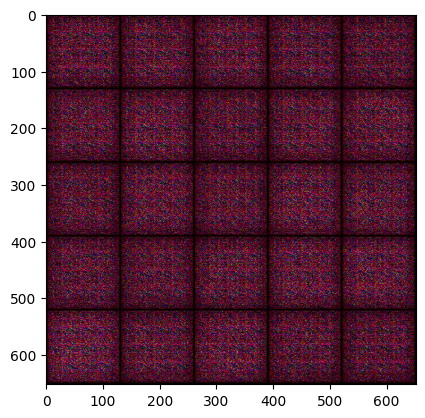

In [ ]:
noise = gen_noise(cur_bs,z_dim)
fake = gen(noise)
show(fake)